In [28]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.pipeline import Pipeline
from scipy import stats
from joblib import dump
from joblib import load
import xgboost as xgb
import matplotlib.pyplot as plt

In [3]:
project_dir = Path.cwd().parent
data_dir = project_dir / 'data'
raw_data_dir = data_dir / 'raw'
interim_data_dir = data_dir / 'interim'

# Load data

In [34]:
df_train = pd.read_csv(raw_data_dir / 'train.csv')
df_test = pd.read_csv(raw_data_dir / 'test.csv')
X_train = np.load(interim_data_dir / 'X_train.npy')
X_val = np.load(interim_data_dir / 'X_val.npy')
y_train = np.load(interim_data_dir / 'y_train.npy')
y_val = np.load(interim_data_dir / 'y_val.npy')
X_test = np.load(interim_data_dir / 'X_test.npy')

# Baseline

The base line prediction is simply to make them all negative.

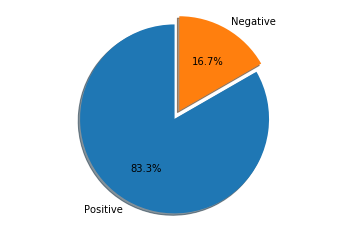

In [19]:
labels = 'Positive', 'Negative'
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

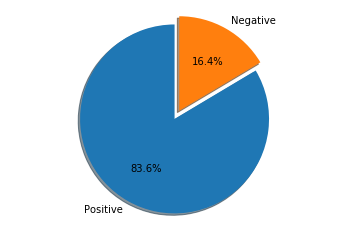

In [22]:
labels = 'Positive', 'Negative'
pos_count = (y_val == 1).sum()
neg_count = (y_val == 0).sum()
sizes = [pos_count, neg_count]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [21]:
preds = [1] * len(y_val)
roc_auc_score(y_val, preds)

0.5

# XGB

In [23]:
clf_xgb = xgb.XGBClassifier()

In [24]:
clf_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [26]:
preds = clf_xgb.predict(X_val)
probs = clf_xgb.predict_proba(X_val)

In [32]:
X_val.shape

(1600, 20)

In [35]:
len(y_val)

1600

In [39]:
auc = roc_auc_score(y_val, probs[:, 1])
tpr, fpr, threshold = roc_curve(y_val, probs[:, 1])
auc

0.7032770148252003

# RandomizedSearchCV

In [35]:
# test
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Id           8000 non-null   int64  
 1   GP           8000 non-null   int64  
 2   MIN          8000 non-null   float64
 3   PTS          8000 non-null   float64
 4   FGM          8000 non-null   float64
 5   FGA          8000 non-null   float64
 6   FG%          8000 non-null   float64
 7   3P Made      8000 non-null   float64
 8   3PA          8000 non-null   float64
 9   3P%          8000 non-null   float64
 10  FTM          8000 non-null   float64
 11  FTA          8000 non-null   float64
 12  FT%          8000 non-null   float64
 13  OREB         8000 non-null   float64
 14  DREB         8000 non-null   float64
 15  REB          8000 non-null   float64
 16  AST          8000 non-null   float64
 17  STL          8000 non-null   float64
 18  BLK          8000 non-null   float64
 19  TOV   

In [38]:
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('classifier', xgb.XGBClassifier(
            objective='binary:logistic',
            use_label_encoder=False,
            eval_metric='logloss'
        ))
])

param_dist = {
    'pca__n_components': stats.randint(1, X_train.shape[1]),
    'classifier__n_estimators': stats.randint(150, 1000),
    'classifier__learning_rate': stats.uniform(0.01, 0.6),
    'classifier__subsample': stats.uniform(0.3, 0.9),
    'classifier__max_depth': [3, 4, 5, 6, 7, 8, 9],
    'classifier__colsample_bytree': stats.uniform(0.5, 0.9),
    'classifier__min_child_weight': [1, 2, 3, 4]
}

cv = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    random_state=42,
    n_iter=5,
    cv=5,
    n_jobs=-1
)

cv.fit(X_train, y_train)

c:\users\mactuary\.virtualenvs\assignment_1-9rwzg4k3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.79828125 0.7871875         nan        nan        nan]
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('pca', PCA()),
                                             ('classifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            eval_metric='logloss',
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            intera

In [41]:
pd.DataFrame(cv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__colsample_bytree,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__subsample,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.346427,0.125135,0.014600,0.003666,0.837086,0.580429,5,4,850,0.837165,19,{'classifier__colsample_bytree': 0.83708610696...,0.790625,0.800000,0.796875,0.796875,0.807031,0.798281,0.005331,1
1,9.774795,4.753663,0.013601,0.003878,0.589977,0.285549,7,4,813,0.8858,2,{'classifier__colsample_bytree': 0.58997742423...,0.800000,0.775781,0.788281,0.785937,0.785937,0.787188,0.007728,2
2,0.044402,0.002058,0.000000,0.000000,1.149799,0.573132,4,4,426,0.855733,12,{'classifier__colsample_bytree': 1.14979889504...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,0.044201,0.001327,0.000000,0.000000,0.520756,0.324865,9,2,625,1.17638,15,{'classifier__colsample_bytree': 0.52075618253...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,0.030599,0.002247,0.000000,0.000000,0.910463,0.481106,5,4,716,1.184908,3,{'classifier__colsample_bytree': 0.91046298579...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5


## Predictions

In [48]:
preds = cv.predict(X_val)
probs = cv.predict_proba(X_val)

In [47]:
len(probs[:, 1])

3799

In [49]:
fpr, tpr, thresholds = roc_curve(y_val, probs[:, 1])
roc_auc_score(y_val, probs[:, 1])

0.6274645864556879